# 15장 RNN : LSTM (Long Short-Term Memory)
---
- Dates : Sep 11, 2024  
- Author : JaeEun Yoo
---

## LSTM을 활용하여 구글 주가 예측하기
- 7일간의 데이터를 활용하여 다음 날 종가(Close) 예측하기



### Import module

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset

import warnings
warnings.filterwarnings('ignore')


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# device = torch.device("mps")
print(str(device) + " is available")

cpu is available


In [3]:
# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

### Load dataset

In [4]:
# 데이터 불러오기
df = pd.read_csv('./data-02-stock_daily.csv')

In [5]:
df

,Open,High,Low,Volume,Close
0,828.659973,833.450012,828.349976,1247700,831.659973
1,823.020020,828.070007,821.655029,1597800,828.070007
2,819.929993,824.400024,818.979980,1281700,824.159973
3,819.359985,823.000000,818.469971,1304000,818.979980
4,819.000000,823.000000,816.000000,1053600,820.450012
...,...,...,...,...,...
727,599.992707,604.832763,562.192568,147100,567.002574
728,558.712504,568.452595,558.712504,7900,567.162558
729,566.892592,567.002574,556.932537,10800,556.972503
730,561.202549,566.432590,558.672539,41200,559.992565


### Initialize the parameters

In [6]:
# 7일간의 데이터가 입력으로 들어가고 batch size는 임의로 지정
time_step = 7
batch = 100

learning_rate = 1e-4
epochs = 200
batch_size = 16

data_dim = 5
hidden_dim = 8 
output_dim = 1 

In [7]:
# 데이터를 역순으로 정렬하여 전체 데이터의 70% 학습, 30% 테스트에 사용
df = df[::-1]  
train_size = int(len(df)*0.7)
train_set = df[0:train_size]  
test_set = df[train_size:]

In [8]:
train_set

,Open,High,Low,Volume,Close
731,568.002570,568.002570,552.922516,13100,558.462551
730,561.202549,566.432590,558.672539,41200,559.992565
729,566.892592,567.002574,556.932537,10800,556.972503
728,558.712504,568.452595,558.712504,7900,567.162558
727,599.992707,604.832763,562.192568,147100,567.002574
...,...,...,...,...,...
224,738.599976,750.340027,737.000000,1576700,749.909973
223,750.059998,752.799988,742.429993,1134200,745.289978
222,738.000000,742.799988,735.369995,1132300,737.799988
221,735.770020,746.239990,735.559998,1053700,745.690002


### Dataset Normalization

In [9]:
# Input scale
scaler_x = MinMaxScaler()
scaler_x.fit(train_set.iloc[:, :-1])

train_set.iloc[:, :-1] = scaler_x.transform(train_set.iloc[:, :-1])
test_set.iloc[:, :-1] = scaler_x.transform(test_set.iloc[:, :-1])

# Output scale
scaler_y = MinMaxScaler()
scaler_y.fit(train_set.iloc[:, [-1]])

train_set.iloc[:, [-1]] = scaler_y.transform(train_set.iloc[:, [-1]])
test_set.iloc[:, [-1]] = scaler_y.transform(test_set.iloc[:, [-1]])


In [10]:
train_set.min()

Open      0.0
High      0.0
Low       0.0
Volume    0.0
Close     0.0
dtype: float64

In [11]:
train_set.max()

Open      1.0
High      1.0
Low       1.0
Volume    1.0
Close     1.0
dtype: float64

### Make Dataset

In [12]:
# 데이터셋 생성 함수
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i+seq_length, :]
        _y = time_series[i+seq_length, [-1]]
        # print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)


In [13]:
X_train, y_train = build_dataset(np.array(train_set), time_step)
X_test, y_test = build_dataset(np.array(test_set), time_step)

In [14]:
X_train.shape

(505, 7, 5)

In [15]:
y_train.shape

(505, 1)

In [16]:
# 텐서로 변환
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

In [17]:
X_train_tensor.shape

torch.Size([505, 7, 5])

In [18]:
# 텐서 형태로 데이터 정의
dataset = TensorDataset(X_train_tensor, y_train_tensor)

dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=True,  
                        drop_last=True)

### Intialize Model

In [19]:
class Net(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            # dropout = 0.1,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True) 
        
    # 학습 초기화를 위한 함수
    def reset_hidden_state(self): 
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim))
    
    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x

In [20]:
def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
     
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs
    
    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        
        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
            
            # seq별 hidden state reset
            model.reset_hidden_state()
            
            # H(x) 계산
            outputs = model(x_train)
                
            # cost 계산
            loss = criterion(outputs, y_train)                    
            
            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss/total_batch
               
        train_hist[epoch] = avg_cost        
        
        if (epoch+1) % verbose == 0:
            print('Epoch:', '%04d' % (epoch+1), 'train loss :', '{:.4f}'.format(avg_cost))
            
        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            
            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')
                
                break
            
    return model.eval(), train_hist

In [21]:
# 모델 학습
net = Net(data_dim, hidden_dim, time_step, output_dim, 1).to(device)  
model, train_hist = train_model(net, dataloader, num_epochs = epochs, lr = learning_rate, verbose = 20, patience = 10)

Epoch: 0019 train loss : 0.1434
Epoch: 0039 train loss : 0.0151
Epoch: 0059 train loss : 0.0042
Epoch: 0079 train loss : 0.0034
Epoch: 0099 train loss : 0.0031
Epoch: 0119 train loss : 0.0030
Epoch: 0139 train loss : 0.0029
Epoch: 0159 train loss : 0.0027
Epoch: 0179 train loss : 0.0026

 Early Stopping


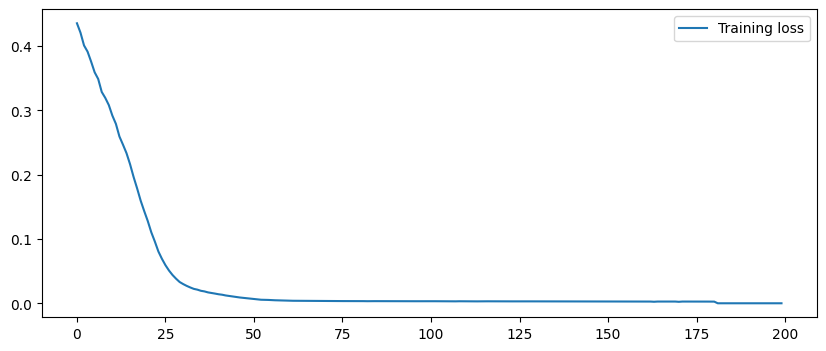

In [22]:
# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

In [23]:
# 예측 테스트
with torch.no_grad(): 
    pred = []
    for pr in range(len(X_test_tensor)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(X_test_tensor[pr], 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # INVERSE
    pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse = scaler_y.inverse_transform(y_test_tensor)

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(pred_inverse, testY_inverse))

MAE SCORE :  15.310326930984214


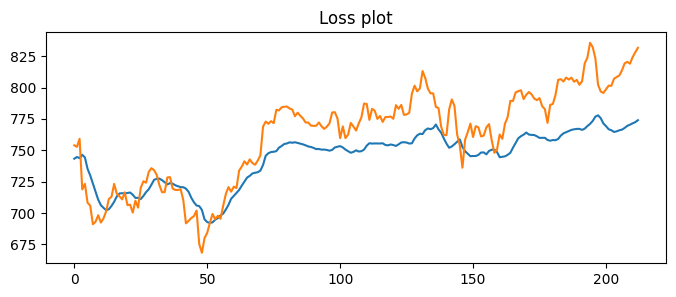

In [30]:
fig = plt.figure(figsize=(8,3))
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label = 'pred')
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label = 'true')
plt.title("Loss plot")
plt.show()